# Simple Azure ML Pipeline Tutorial using cats vs dogs dataset

In this notebook-based tutorial, we will create and run a Azure ML pipeline
for a simple cats vs dogs classification model using custom components.
The pipeline will consist of following components:
- Data ingestion
- Trainer
- Evaluator


## Set Up
We first need to install the azure-ai-ml and azureml Python packages and download
the dataset which we will use for our model.

In [ ]:
!pip install azure-ai-ml

In [ ]:
!pip install mldesigner

In [ ]:
!pip install azureml

## Connect to workspace

In [153]:
# Handle to the workspace
from azure.ai.ml import MLClient, Input

# Authentication package
from azure.identity import DefaultAzureCredential, InteractiveBrowserCredential

try:
    credential = DefaultAzureCredential()
    # Check if given credential can get token successfully.
    credential.get_token("https://management.azure.com/.default")
except Exception as ex:
    # Fall back to InteractiveBrowserCredential in case DefaultAzureCredential not work
    credential = InteractiveBrowserCredential()

In [154]:
# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="SUBSCRIPTION_ID",
    resource_group_name="RESOURCE_GROUP_NAME",
    workspace_name="WORKSPACE_NAME",
)

compute_instance = "COMPUTE_INSTANCE"

## Create a directory for pipeline components

In [155]:
import os

components_dir = "./components"
os.makedirs(components_dir, exist_ok=True)

data_ingestion_dir = os.path.join(components_dir, "data_ingestion")
os.makedirs(data_ingestion_dir, exist_ok=True)

evaluator_dir = os.path.join(components_dir, "evaluator")
os.makedirs(evaluator_dir, exist_ok=True)

## Set up necessary variables

There are some variables used to define a pipeline. You can customize these
variables as you want. By default all output from the pipeline will be
generated under the current directory.

In [2]:
import os

_data_ingestion_file = os.path.join(data_ingestion_dir, 'data_ingestion_component.py')
_evaluator_file = os.path.join(evaluator_dir, 'evaluator_component.py')

data_root ='../datasets/dogs_vs_cats_small2'
train_dir = os.path.join(data_root, 'train')
validation_dir = os.path.join(data_root, 'test')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures


num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val


print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)
print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 12
total training dog images: 12
total validation cat images: 7
total validation dog images: 7
--
Total training images: 24
Total validation images: 14


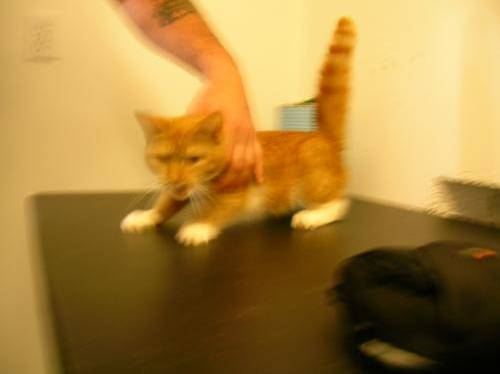

In [3]:
from IPython.display import Image

sample_image = os.path.join(data_root, "train", "cats", "cat.0.jpg")
Image(filename=sample_image)

## Upload the dataset into Azure ML studio and read them into datasets

Creating Data Assets for Train and Test datasets. We followed this [link on Microsoft Doc](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-data-assets?view=azureml-api-2&preserve-view=true&tabs=Python-SDK)

### Creating Data Assets V2

In [159]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

# Supported paths include:
# local: './<path>/<file>'
# blob:  'https://<account_name>.blob.core.windows.net/<container_name>/<path>/<file>'
# ADLS gen2: 'abfss://<file_system>@<account_name>.dfs.core.windows.net/<path>/<file>'
# Datastore: 'azureml://datastores/<data_store_name>/paths/<path>/<file>'
train_ds_path = '../datasets/dogs_vs_cats_small2/train'
test_ds_path = '../datasets/dogs_vs_cats_small2/test'

train_ds = Data(
    path=train_ds_path,
    type=AssetTypes.URI_FOLDER,
    description="20 images of cats and dogs for training purposes",
    name="dogs_vs_cats_train",
)


test_ds = Data(
    path=test_ds_path,
    type=AssetTypes.URI_FOLDER,
    description="10 images of cats and dogs for validation purposes",
    name="dogs_vs_cats_test",
)

uri_folder_train_data_asset = ml_client.data.create_or_update(train_ds)
uri_folder_test_data_asset = ml_client.data.create_or_update(test_ds)

## Write data ingestion code

In [160]:
%%writefile {_data_ingestion_file}
import os
from pathlib import Path
from mldesigner import command_component, Input, Output
import json

@command_component(
    name="data_ingestion_component",
    version="1.2",
    display_name="Data ingestion",
    description="Brings the train and test datasets into the pipeline",
    environment=dict(
        conda_file=Path(__file__).parent / "conda.yaml",
        image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04",
    ),
)
def data_ingest(
    uri_folder_train_data_asset_path: Input(type="string"),
    uri_folder_test_data_asset_path: Input(type="string"),
    train_data_path: Input(type="uri_folder"),
    test_data_path: Input(type="uri_folder"),
    output_train_data: Output(type="uri_folder"),
    output_test_data: Output(type="uri_folder")
):
    print("Data ingestion is running ...")
    
    train_mltable_path, train_annotations_file = create_JSONL(train_data_path, output_train_data, uri_folder_train_data_asset_path)

    # Create and save mltable
    train_mltable_file_contents = create_ml_table_file(
        os.path.basename(train_annotations_file)
    )
    save_ml_table_file(train_mltable_path, train_mltable_file_contents)


    test_mltable_path, test_annotations_file = create_JSONL(test_data_path, output_test_data, uri_folder_test_data_asset_path)

    # Create and save mltable
    test_mltable_file_contents = create_ml_table_file(
        os.path.basename(test_annotations_file)
    )
    save_ml_table_file(test_mltable_path, test_mltable_file_contents)


def create_JSONL(base_dir, output_dir, uri_folder_data_asset):
    # We'll copy each JSONL file within its related MLTable folder
    mltable_path = output_dir


    # Path to the training and validation files
    annotations_file = os.path.join(mltable_path, "annotations.jsonl")

    # Baseline of json line dictionary
    json_line_sample = {
        "image_url": uri_folder_data_asset,
        "label": "",
    }

    # Scan each sub directary and generate a jsonl line per image, distributed on train and valid JSONL files
    with open(annotations_file, "w") as f:
        for class_name in os.listdir(base_dir):
            sub_dir = os.path.join(base_dir, class_name)
            if not os.path.isdir(sub_dir):
                continue

            # Scan each sub directary
            print(f"Parsing {sub_dir}")
            for image in os.listdir(sub_dir):
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"{class_name}/{image}"
                json_line["label"] = class_name[:-1]
                f.write(json.dumps(json_line) + "\n")


    return mltable_path, annotations_file

def create_ml_table_file(filename):
    """Create ML Table definition"""

    return (
        "paths:\n"
        "  - file: ./{0}\n"
        "transformations:\n"
        "  - read_json_lines:\n"
        "        encoding: utf8\n"
        "        invalid_lines: error\n"
        "        include_path_column: false\n"
        "  - convert_column_types:\n"
        "      - columns: image_url\n"
        "        column_type: stream_info"
    ).format(filename)


def save_ml_table_file(output_path, mltable_file_contents):
    with open(os.path.join(output_path, "MLTable"), "w") as f:
        f.write(mltable_file_contents)

Overwriting ./components/data_ingestion/data_ingestion_component.py


In [161]:
%%writefile {data_ingestion_dir}/conda.yaml
name: data_ingestion_conda_env
channels:
  - defaults
dependencies:
  - python=3.7.11
  - pip=20.0
  - pip:
    - mldesigner==0.1.0b4

Overwriting ./components/data_ingestion/conda.yaml


## Model Evaluator

In [163]:
%%writefile {_evaluator_file}
import os
from pathlib import Path
from mldesigner import command_component, Input, Output
import mlflow
import pandas as pd
import mlflow.pyfunc
import json
import matplotlib.pyplot as plt
from mlflow.tracking.client import MlflowClient

@command_component(
    name="evaluator_component",
    version="1.0",
    display_name="Evaluator",
    description="Evaluates the model",
    environment=dict(
        conda_file=Path(__file__).parent / "conda.yaml",
        image="mcr.microsoft.com/azureml/openmpi4.1.0-ubuntu20.04",
    ),
)
def evaluator(
    best_model: Input(),
    evaluation_results: Output(type="uri_folder"),
):
    print("Evaluator is running ...")

    model = mlflow.pyfunc.load_model(best_model)
    run_id = model.metadata.run_id
    mlflow_client = MlflowClient()
    best_run = mlflow_client.get_run(run_id)
    
    metrics = pd.DataFrame(best_run.data.metrics, index=[0]).T

    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Data to plot
    metric_names = metrics.index
    metric_values = metrics[0]

    # Create bar chart
    ax.bar(metric_names, metric_values)

    # Rotate x labels for better visibility
    plt.xticks(rotation=90)

    # Title and labels
    plt.title('Metrics')
    plt.xlabel('Metric Names')
    plt.ylabel('Metric Values')

    # Show the plot
    plt.tight_layout()
   
    # Save the plot as PNG in the specified directory
    save_path = os.path.join(evaluation_results, 'model_metrics.png')
    plt.savefig(save_path)


Overwriting ./components/evaluator/evaluator_component.py


In [164]:
%%writefile {evaluator_dir}/conda.yaml
name: evaluator_conda_env
channels:
  - defaults
dependencies:
  - python=3.8
  - pip=20.0
  - pip:
    - azureml-core
    - azureml-mlflow
    - azureml-train-automl
    - azureml-sdk[automl]
    - mldesigner==0.1.0b4
    - mlflow
    - pandas
    - azureml-automl-dnn-vision
    - matplotlib


Overwriting ./components/evaluator/conda.yaml


## Loading the component when it is Python function

In [165]:
%reload_ext autoreload
%autoreload 2

# load component function from component python file
from components.data_ingestion.data_ingestion_component import data_ingest
from components.evaluator.evaluator_component import evaluator

### Loading the datasets

In [166]:
train_ds_path = Input(type= "uri_folder", path = "../datasets/dogs_vs_cats_small2/train")
test_ds_path = Input(type= "uri_folder", path = "../datasets/dogs_vs_cats_small2/test")

## Pipeline definition

In [167]:
from azure.ai.ml.dsl import pipeline
from azure.ai.ml import load_component
from azure.ai.ml.automl import (
    image_classification,
    SearchSpace,
    ClassificationPrimaryMetrics)
from azure.ai.ml.sweep import BanditPolicy, Choice, Uniform
from azure.ai.ml.entities import Environment
from azure.ai.ml import MLClient, Output, command


# define a pipeline containing 3 nodes: Prepare data node, train node, and score node
@pipeline(
    default_compute=compute_instance,
)
def cat_vs_dog_classifier():

    step1 = data_ingest(train_data_path = train_ds_path, uri_folder_train_data_asset_path=uri_folder_train_data_asset.path,
                        test_data_path = test_ds_path, uri_folder_test_data_asset_path=uri_folder_test_data_asset.path)

    step2 = image_classification(
        training_data=step1.outputs.output_train_data,
        validation_data=step1.outputs.output_test_data,
        target_column_name="label",
        primary_metric=ClassificationPrimaryMetrics.ACCURACY,
        # currently need to specify outputs "mlflow_model" explictly to reference it in following nodes
        outputs={"best_model": Output(type="mlflow_model")}
    )

    step2.set_limits(
        max_trials=1,
        max_concurrent_trials=1,
    )

    step3 = evaluator(best_model = step2.outputs.best_model)
   

# create a pipeline
pipeline_job = cat_vs_dog_classifier()

In [168]:
pipeline_job = ml_client.jobs.create_or_update(
    pipeline_job, experiment_name="dogs_vs_cats_experiment_Evaluator", description="Data ingestion, AutoML trainer and Evaluator."
)
pipeline_job

Uploading evaluator (0.0 MBs): 100%|██████████| 2127/2127 [00:00<00:00, 37990.07it/s]




Experiment,Name,Type,Status,Details Page
dogs_vs_cats_experiment_Evaluator,lucid_chicken_x83bw69j1q,pipeline,Preparing,Link to Azure Machine Learning studio


In [ ]:
# wait until the job completes
ml_client.jobs.stream(pipeline_job.name)